In [61]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *


3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]


In [62]:
#import training dataset

dataset_snow = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/slip_dataset_all.pkl')

print(dataset_snow.head())

   init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
0         0.0         0.0         0.0            0.0             0.0   
1         0.0         0.0         0.0            0.0             0.0   
2         0.0         0.0         0.0            0.0             0.0   
3         0.0         0.0         0.0            0.0             0.0   
4         0.0         0.0         0.0            0.0             0.0   

   init_icp_yaw  calib_step  cmd_left_0  cmd_right_0  cmd_left_1  ...  \
0           0.0         0.0    0.000000     0.000000    6.337527  ...   
1           0.0         0.0    6.337527     6.558533    6.337527  ...   
2           0.0         0.0    6.337527     6.558533    6.337527  ...   
3           0.0         1.0   -5.933710     5.305197   -5.933710  ...   
4           0.0         1.0   -5.933710     5.305197   -5.933710  ...   

   body_vel_disturption_yaw_30  body_vel_disturption_yaw_31  \
0                     0.001605                     0.006716   
1 

In [87]:
# extract body_vel_distruptions arrays (output arrays)

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)
    
body_vel_disturption_x_array = dataset_snow[str_body_vel_disturption_x_list].to_numpy()
body_vel_disturption_y_array = dataset_snow[str_body_vel_disturption_y_list].to_numpy()
body_vel_disturption_yaw_array = dataset_snow[str_body_vel_disturption_yaw_list].to_numpy()

y_train_longitudinal_slip = body_vel_disturption_x_array.flatten()
y_train_lateral_slip = body_vel_disturption_y_array.flatten()
y_train_angular_slip = body_vel_disturption_yaw_array.flatten()

print(np.max(y_train_angular_slip))

2.8881285042196287


In [64]:
# extract interpolated_icp

str_icp_interpolated_x_list = []
str_icp_interpolated_y_list = []
str_icp_interpolated_yaw_list = []
for i in range(0, 40):
    str_icp_interpolated_x_i = 'icp_interpolated_x_' + str(i)
    str_icp_interpolated_y_i = 'icp_interpolated_y_' + str(i)
    str_icp_interpolated_yaw_i = 'icp_interpolated_yaw_' + str(i)
    str_icp_interpolated_x_list.append(str_icp_interpolated_x_i)
    str_icp_interpolated_y_list.append(str_icp_interpolated_y_i)
    str_icp_interpolated_yaw_list.append(str_icp_interpolated_yaw_i)
    
icp_interpolated_x_array = dataset_snow[str_icp_interpolated_x_list].to_numpy()
icp_interpolated_y_array = dataset_snow[str_icp_interpolated_y_list].to_numpy()
icp_interpolated_yaw_array = dataset_snow[str_icp_interpolated_yaw_list].to_numpy()

In [65]:
# extract icp vels

str_icp_vel_x_list = []
str_icp_vel_y_list = []
str_icp_vel_yaw_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    str_icp_vel_x_list.append(str_icp_vel_x_i)
    str_icp_vel_y_list.append(str_icp_vel_y_i)
    str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
    
icp_vel_x_array = dataset_snow[str_icp_vel_x_list].to_numpy()
icp_vel_y_array = dataset_snow[str_icp_vel_y_list].to_numpy()
icp_vel_yaw_array = dataset_snow[str_icp_vel_yaw_list].to_numpy()

In [66]:
# extract cmd_body_vel arrays (input arrays)

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
idd_body_vel_x_array = dataset_snow[idd_body_vel_x_str_list].to_numpy()
idd_body_vel_y_array = dataset_snow[idd_body_vel_y_str_list].to_numpy()
idd_body_vel_yaw_array = dataset_snow[idd_body_vel_yaw_str_list].to_numpy()

x_train = np.column_stack((idd_body_vel_x_array.flatten(), idd_body_vel_yaw_array.flatten()))

0.04403050991009042
0.05318392508050409
[ 0.0025532  -0.00852464 -0.01981363 -0.03161335 -0.04396027 -0.05677934
 -0.0695757  -0.08168755 -0.09202539 -0.09949836 -0.10286035 -0.10108302
 -0.09332637 -0.07893764 -0.0575554  -0.02853041  0.00803849  0.05013096
  0.09543166  0.14351986  0.1939329   0.24411157  0.29160204  0.3360414
  0.37804316  0.42016993  0.46511009  0.51381796  0.56634274  0.62063834
  0.67451093  0.72750372  0.77945392  0.83106249  0.88252935  0.93436991
  0.98628156  1.03858016  1.09109832  1.14419649]


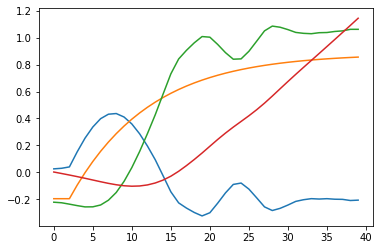

In [97]:
test_window = 18

plt.plot(body_vel_disturption_yaw_array[test_window, :])
plt.plot(idd_body_vel_yaw_array[test_window, :])
plt.plot(icp_vel_yaw_array[test_window, :])
plt.plot(icp_interpolated_yaw_array[test_window, :])

# plt.ylim(-1.5, 1.5)

print(dataset_snow.loc[test_window]['icp_vel_x_1'])
print(dataset_snow.loc[test_window]['icp_vel_x_2'])
print(icp_interpolated_yaw_array[test_window])
